In [1]:
import sys

sys.path.insert(0, "/home/tsurendr/OAI_Github_scripts_paper_modifications")
sys.path

['/home/tsurendr/OAI_Github_scripts_paper_modifications',
 '/home/tsurendr/OAI_Github_scripts_paper_modifications/Kaplan_Meier_Analysis',
 '/home/tsurendr/.conda/envs/neuro/lib/python310.zip',
 '/home/tsurendr/.conda/envs/neuro/lib/python3.10',
 '/home/tsurendr/.conda/envs/neuro/lib/python3.10/lib-dynload',
 '',
 '/home/tsurendr/.conda/envs/neuro/lib/python3.10/site-packages',
 '/home/tsurendr/.conda/envs/neuro/lib/python3.10/site-packages/deepsurv-0.2.1-py3.10.egg']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import lifelines
import math
import sys
from statistics import stdev
from lifelines.statistics import logrank_test, multivariate_logrank_test,pairwise_logrank_test

# Set the path of SBL and merge1 files and read the files
loc_data = "/data_1/OAI_SBL_Analysis_Data/"
loc_module = "/home/tsurendr/OAI_Github_scripts"
loc_data_SBL = loc_data + "SBL_0904.csv"
loc_merge1 = loc_data + "merge1_KL.csv"
raw_data_SBL = pd.read_csv(loc_data_SBL)
merge1 = pd.read_csv(loc_merge1)
# load custom module 
sys.path.append(loc_module)

In [3]:
sbl_col_names = ["F" + str(i) for i in range(200)] + [
    "T" + str(i) for i in range(200)
]  # femur: F0~ F199 , tibia: T0 ~ T199
sbl_col_names_femur = ["F" + str(i) for i in range(200)]
sbl_col_names_tibia = ["T" + str(i) for i in range(200)]

Organize with the following 3 variables:

- data_SBL_both
- data_SBL_femur
- data_SBL_tibia


In [4]:
##################################
# normalize SBL for both femur and tibia at once #
##################################

# sum of all the absolute value of sbl difference.
sbl_difference_absolute = pd.DataFrame(raw_data_SBL)
sbl_difference_absolute.drop(columns=sbl_difference_absolute.columns[0], axis=1,  inplace=True)
sbl_difference_absolute.drop(columns=sbl_difference_absolute.columns[-1], axis=1,  inplace=True)
sbl_difference_absolute.drop(columns=sbl_difference_absolute.columns[-1], axis=1,  inplace=True)
print(sbl_difference_absolute)
list_max = []
for index, row in sbl_difference_absolute.iterrows():
    #look for column in each row with biggest difference.
    col_val = sbl_difference_absolute.idxmax()
    val_list = []
    for i in sbl_difference_absolute.columns:
        val_list.append(sbl_difference_absolute.at[index,i])
    val_list.sort(reverse=True)
    top_percentile = val_list[0:400]
    #now find the normalized SBL value in that column
    sbl_normalized = (sum(top_percentile))
    list_max.append(sbl_normalized)

sbl_difference_absolute.name = "normalized_sbl"
# Add sum of all the absolute value of sbl difference to data_SBL
df_normalized_SBL_both = pd.DataFrame({'normalized_sbl':list_max})
print(df_normalized_SBL_both)

       F0        F1        F2         F3         F4         F5         F6  \
0     4.0  3.532079  2.297244   0.093239   0.000000   0.000000   0.000000   
1     3.0  0.180653  3.549661  31.076046  46.106151  55.543236  62.600355   
2     3.0  5.358804  5.951435   3.999878   3.000000   3.000000   2.609164   
3     0.0  0.000000  1.037586   8.400008  37.597578  60.490127  69.915004   
4     0.0  0.000000  0.000000   0.000000   0.395532   3.030169   7.693455   
...   ...       ...       ...        ...        ...        ...        ...   
9429  4.0  0.312965  0.808443   7.923382  19.633445  36.613096  57.591739   
9430  0.0  0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
9431  0.0  0.000000  0.000000   0.000000   0.000000   0.000000   0.468768   
9432  0.0  0.000000  0.000000   0.000000   0.049816   5.269794  16.079861   
9433  6.0  1.408218  0.000000   0.000000   0.000000   0.000000   0.000000   

             F7         F8         F9  ...       T190       T191       T192

In [5]:
# Combining 3 Variables: df_normalized_SBL_both, df_normalized_SBL_femur, df_normalized_SBL_tibia
data_SBL = pd.merge(
    raw_data_SBL, df_normalized_SBL_both, right_index=True, left_index=True
)  # merge df_normalized_SBL_both


In [6]:
# Splitting data by knee side(right/left) and formatting columns appropriately 

print("total number of baseline knees", len(data_SBL))
data_SBL["id"] = data_SBL["id"].astype(str)
data_BioMarkers = pd.read_csv(loc_data + "Biomarker_data.csv")
data_SBL = data_SBL.drop(["Unnamed: 0"], axis=1)
data_BioMarkers = data_BioMarkers.drop(["Unnamed: 0"], axis=1)
side_SBL_temp = data_SBL.groupby("SIDE")
side_1_SBL_Right = side_SBL_temp.get_group(1)
side_2_SBL_Left = side_SBL_temp.get_group(2)

total number of baseline knees 9434


In [7]:
print("total number of right knees", len(side_1_SBL_Right))
print("total number of left knees", len(side_2_SBL_Left))

total number of right knees 4727
total number of left knees 4707


In [8]:
# settings
NUM_YEARS = 11.0  
encoding = "utf-8"
# read and preprocessing
raw_df = pd.read_sas(loc_data + "outcomes99.sas7bdat")
# must censor data per knee
print("Before data drop mri data", len(raw_df))
df = raw_df.dropna(axis=0, subset=["V99RNTCNT"])
print("complete mri data", len(df))
print(f"number of drop: {len(raw_df)-len(df)}")
df = df.copy()
df.loc[:, "id"] = df["id"].apply(lambda x: str(x, encoding))

merge1 = merge1.dropna(axis=0, subset=["P02SEX"])
merge1 = merge1.dropna(axis=0, subset=["V00AGE"])
merge1 = merge1.dropna(axis=0, subset=["V00XRJSM"])
merge1 = merge1.dropna(axis=0, subset=["V00XRJSL"])
merge1["id"] = merge1["id"].astype(str)
merge1_temp = merge1.groupby("SIDE")
merge1_right = merge1_temp.get_group(1)
merge1_left = merge1_temp.get_group(2)

df_8_years = df[df["V99RNTCNT"] <= NUM_YEARS].copy()  
print("oai Data: ", len(df_8_years))

Before data drop mri data 4796
complete mri data 4650
number of drop: 146
oai Data:  4650


In [9]:
# KL Grade information preprocessing for right knees

data_KL_grade_right = pd.read_csv(loc_data + "rightFilteredklMEAS.csv")
data_KL_grade_right = data_KL_grade_right.drop(["Unnamed: 0"], axis=1)
data_KL_grade_right = data_KL_grade_right.dropna(axis=0, subset=["V00XRKLR"])
data_KL_grade_right["id"] = data_KL_grade_right["id"].astype(str)

In [10]:
# KL Grade information preprocessing for left knees


data_KL_grade_left = pd.read_csv(loc_data + "leftFilteredklMEAS.csv")
data_KL_grade_left = data_KL_grade_left.drop(["Unnamed: 0"], axis=1)
data_KL_grade_left = data_KL_grade_left.dropna(axis=0, subset=["V00XRKLL"])
data_KL_grade_left["id"] = data_KL_grade_left["id"].astype(str)

In [11]:
# BML information preprocessing for right knees. 
# right side
data_BML_right = pd.read_csv(loc_data + "rightFilteredbmlMoaks.csv")
data_BML_right["id"] = data_BML_right["id"].astype(str)
data_BML_right = data_BML_right.drop(["Unnamed: 0"], axis=1)
data_BML_right = data_BML_right.dropna(axis=0, subset=['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP',
'V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP'])

# For verification after data processing
print("bml right Data: ", len(data_BML_right))


bml right Data:  1587


In [12]:
# Merging all right knee info, including demographics, TKR, KL Grade, BML, etc...
oai_bml_merge_right = pd.merge(df_8_years, data_BML_right, how="inner", on=["id"])
oai_bml_SBL_KL_merge_right_pre = pd.merge(
    oai_bml_merge_right, side_1_SBL_Right, how="inner", on=["id"]
)
print(len(oai_bml_SBL_KL_merge_right_pre))

oai_bml_SBL_KL_merge_right_age_pre_1 = pd.merge(
    oai_bml_SBL_KL_merge_right_pre, data_KL_grade_right, how="inner", on=["id"]
)
oai_bml_SBL_KL_merge_right = pd.merge(
    oai_bml_SBL_KL_merge_right_age_pre_1, merge1_right, how="inner", on=["id"]
)
print(len(oai_bml_SBL_KL_merge_right))

oai_bml_SBL_KL_merge_right.drop_duplicates(subset=["id"], inplace=True, keep="last")
oai_bml_SBL_KL_merge_right.reset_index(drop=True, inplace=True)
print(len(oai_bml_SBL_KL_merge_right))


1587
1584


1257


In [13]:
if 'V00XRJSM' in oai_bml_SBL_KL_merge_right:
    print(True)
else:
    print(False)

True


In [14]:
if 'V00XRJSL' in oai_bml_SBL_KL_merge_right:
    print(True)
else:
    print(False)

True


In [15]:
# BML information preprocessing for left knees. 
# left side
data_BML_left = pd.read_csv(loc_data + "leftFilteredbmlMoaks.csv")
data_BML_left["id"] = data_BML_left["id"].astype(str)
data_BML_left = data_BML_left.drop(["Unnamed: 0"], axis=1)
data_BML_left = data_BML_left.dropna(axis=0, subset=['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP',
'V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP'])

# For verification after data processing
print("bml left Data: ", len(data_BML_left))

bml left Data:  1366


In [16]:
# Merging all left knee info, including demographics, TKR, KL Grade, BML, etc...
oai_bml_merge_left = pd.merge(df_8_years, data_BML_left, how="inner", on=["id"])
oai_bml_SBL_KL_merge_left_pre = pd.merge(
    oai_bml_merge_left, side_2_SBL_Left, how="inner", on=["id"]
)
oai_bml_SBL_KL_merge_left_age_pre_1 = pd.merge(
    oai_bml_SBL_KL_merge_left_pre, data_KL_grade_left, how="inner", on=["id"]
) 
oai_bml_SBL_KL_merge_left = pd.merge(
    oai_bml_SBL_KL_merge_left_age_pre_1, merge1_left, how="inner", on=["id"]
)
oai_bml_SBL_KL_merge_left.drop_duplicates(subset=["id"], inplace=True, keep="last")
oai_bml_SBL_KL_merge_left.reset_index(drop=True, inplace=True)
print(len(oai_bml_SBL_KL_merge_left))


1083


In [17]:
if 'V00XRJSM' in oai_bml_SBL_KL_merge_left:
    print(True)
else:
    print(False)

True


In [18]:
if 'V00XRJSL' in oai_bml_SBL_KL_merge_left:
    print(True)
else:
    print(False)

True


In [19]:
print(oai_bml_SBL_KL_merge_right['V00XRJSM'].isnull().sum())
print(oai_bml_SBL_KL_merge_right['V00XRJSL'].isnull().sum())

0
0


In [20]:
print(oai_bml_SBL_KL_merge_left['V00XRJSM'].isnull().sum())
print(oai_bml_SBL_KL_merge_left['V00XRJSL'].isnull().sum())

0
0


# Process for restricting dataset


In [21]:
# need 3 groups representing merged femur and tibia. 

femur_column_list = ['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP']

tibia_column_list = ['V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP']

merged_column_list = ['V00MBMSFMA',
'V00MBMSFLA',
'V00MBMSFMC',
'V00MBMSFLC',
'V00MBMSFMP',
'V00MBMSFLP',
'V00MBMSSS',
'V00MBMSTMA',
'V00MBMSTLA',
'V00MBMSTMC',
'V00MBMSTLC',
'V00MBMSTMP',
'V00MBMSTLP']


In [22]:
# Determining the largest BML in each knee based on if it is a Merged, Femur, or Tibia model
# For both left and right knees

# right side
right_knee_tkr = oai_bml_SBL_KL_merge_right[
    (oai_bml_SBL_KL_merge_right["V99RNTCNT"] <= NUM_YEARS)
    & (oai_bml_SBL_KL_merge_right["V99ERKDAYS"].isnull() == False)
]
print("total knees on right side: ", len(oai_bml_SBL_KL_merge_right))
print("censored right knees: ", len(oai_bml_SBL_KL_merge_right) - len(right_knee_tkr))
print("proper right knee tkr: ", len(right_knee_tkr))

oai_bml_SBL_KL_merge_right["right_tkr"] = np.where(
    oai_bml_SBL_KL_merge_right["id"].isin(right_knee_tkr["id"]) == True, 1, 0
)
oai_bml_SBL_KL_merge_right["bml_total_merged"] = oai_bml_SBL_KL_merge_right[merged_column_list].max(axis=1)
oai_bml_SBL_KL_merge_right["bml_total_femur"] = oai_bml_SBL_KL_merge_right[femur_column_list].max(axis=1)
oai_bml_SBL_KL_merge_right["bml_total_tibia"] = oai_bml_SBL_KL_merge_right[tibia_column_list].max(axis=1)
print(oai_bml_SBL_KL_merge_right["bml_total_merged"].unique())


# left side
left_knee_tkr = oai_bml_SBL_KL_merge_left[
    (oai_bml_SBL_KL_merge_left["V99RNTCNT"] <= NUM_YEARS)
    & (oai_bml_SBL_KL_merge_left["V99ELKDAYS"].isnull() == False)
]

print("total knees on left side: ", len(oai_bml_SBL_KL_merge_left))
print("censored left knees: ", len(oai_bml_SBL_KL_merge_left) - len(left_knee_tkr))
print("proper left knee tkr: ", len(left_knee_tkr))


oai_bml_SBL_KL_merge_left["right_tkr"] = np.where(
    oai_bml_SBL_KL_merge_left["id"].isin(left_knee_tkr["id"]) == True, 1, 0
) 

oai_bml_SBL_KL_merge_left["bml_total_merged"] = oai_bml_SBL_KL_merge_left[merged_column_list].max(axis = 1)
oai_bml_SBL_KL_merge_left["bml_total_femur"] = oai_bml_SBL_KL_merge_left[femur_column_list].max(axis = 1)
oai_bml_SBL_KL_merge_left["bml_total_tibia"] = oai_bml_SBL_KL_merge_left[tibia_column_list].max(axis = 1)
print(oai_bml_SBL_KL_merge_left["bml_total_merged"].unique())

print(oai_bml_SBL_KL_merge_right)

total knees on right side:  1257
censored right knees:  1084
proper right knee tkr:  173
[1. 2. 3. 0.]
total knees on left side:  1083
censored left knees:  923
proper left knee tkr:  160
[3. 2. 1. 0.]
           id version  V99RNTCNT V99ERKDATE  V99ERKFLDT  V99ERKRPCF  \
0     9001400   b'10'       11.0        NaT         NaN         NaN   
1     9001695   b'10'        9.0        NaT         NaN         NaN   
2     9001897   b'10'       11.0        NaT         NaN         NaN   
3     9002430   b'10'       11.0 2010-02-15         1.0         3.0   
4     9002817   b'10'       11.0        NaT         NaN         NaN   
...       ...     ...        ...        ...         ...         ...   
1252  9996098   b'10'       11.0        NaT         NaN         NaN   
1253  9996865   b'10'       11.0        NaT         NaN         NaN   
1254  9997381   b'10'       11.0        NaT         NaN         NaN   
1255  9999510   b'10'       11.0        NaT         NaN         NaN   
1256  9999862   b

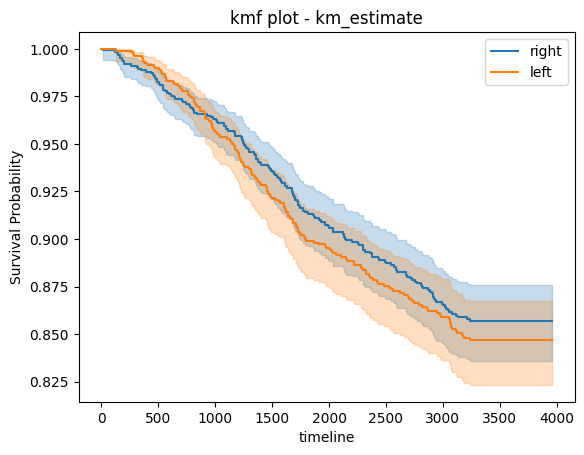

In [23]:
# Determining which patiets had a TKR and if not, what their most recent time of follow-up was.

from time_adder import add_time

oai_SBL_KL_BML_right = add_time(oai_bml_SBL_KL_merge_right, "right")
oai_SBL_KL_BML_left = add_time(oai_bml_SBL_KL_merge_left, "left")

In [24]:
jsn_list = ['V00XRJSM',
'V00XRJSL']
oai_bml_SBL_KL_merge_right["jsn_total_merged"] = oai_bml_SBL_KL_merge_right[jsn_list].max(axis=1)
oai_bml_SBL_KL_merge_left["jsn_total_merged"] = oai_bml_SBL_KL_merge_left[jsn_list].max(axis = 1)


In [25]:
# Selecting columns from left and right knee info, to merge into 1 table for each SBL and BML model

# right side
oai_right_temp_SBL_Merged_right = oai_SBL_KL_BML_right[
    ['id',"time", "right_tkr", "P02SEX", "normalized_sbl",'KL_Grade']
]



# left side
oai_right_temp_SBL_Merged_left = oai_SBL_KL_BML_left[
    ['id',"time", "right_tkr", "P02SEX", "normalized_sbl",'KL_Grade']
]



In [26]:
# merging information for various SBL and BML models based on left and right knee information that was selected previously
oai_right_temp_SBL_Merged_all = pd.concat(
    [oai_right_temp_SBL_Merged_right, oai_right_temp_SBL_Merged_left],
    ignore_index=True,
)


In [27]:



# dropping the the smaller KL grade from patients who have 2 knees in the table in order to avoid confounding variables.
oai_right_temp_SBL_Merged_all = oai_right_temp_SBL_Merged_all.sort_values('KL_Grade').drop_duplicates('id', keep='last').sort_index()

#Checking to make sure each patient has no more than 1 knee in the table
print(len(list(set([x for i,x in enumerate(oai_right_temp_SBL_Merged_all['id'].tolist()) if oai_right_temp_SBL_Merged_all['id'].tolist().count(x) > 1]))))




0


In [28]:
groups_merged = oai_right_temp_SBL_Merged_all.groupby("P02SEX")
males_merged = groups_merged.get_group(1)
females_merged = groups_merged.get_group(2)
# check the gender population; male:1, female:2
print("total males", len(males_merged))
print('total females', len(females_merged))

total males 760
total females 1214


In [29]:
print(oai_right_temp_SBL_Merged_all)

           id    time  right_tkr  P02SEX  normalized_sbl  KL_Grade
0     9001400  3960.0          0       2    45164.758960         1
1     9001695  3240.0          0       2    46544.323822         2
2     9001897  3960.0          0       1    51210.243280         3
3     9002430  1702.0          1       1    52031.060657         2
4     9002817  3960.0          0       2    50311.308905         3
...       ...     ...        ...     ...             ...       ...
2335  9996865  3960.0          0       2    43227.919664         4
2336  9997856  3960.0          0       1    48029.857005         4
2337  9997869  3960.0          0       2    41735.307864         0
2338  9999510  3960.0          0       1    54361.471657         3
2339  9999878  3960.0          0       2    45765.604432         1

[1974 rows x 6 columns]


In [30]:
oai_right_temp_SBL_Merged_all = oai_right_temp_SBL_Merged_all.drop(['id','P02SEX','KL_Grade'], axis = 1)

In [31]:
oai_right_temp_SBL_Merged_all

,time,right_tkr,normalized_sbl
0,3960.0,0,45164.758960
1,3240.0,0,46544.323822
2,3960.0,0,51210.243280
3,1702.0,1,52031.060657
4,3960.0,0,50311.308905
...,...,...,...
2335,3960.0,0,43227.919664
2336,3960.0,0,48029.857005
2337,3960.0,0,41735.307864
2338,3960.0,0,54361.471657


In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer,RobustScaler
time_col = list(oai_right_temp_SBL_Merged_all['time'].copy())
right_tkr_col = list(oai_right_temp_SBL_Merged_all['right_tkr'].copy())
# print(len(time_col), len(right_tkr_col))
oai_right_temp_SBL_Merged_all = oai_right_temp_SBL_Merged_all.drop(['time', 'right_tkr'], axis=1)
scaler = MinMaxScaler()
dataframe = scaler.fit_transform(oai_right_temp_SBL_Merged_all)
oai_right_temp_SBL_Merged_all = pd.DataFrame(dataframe)
oai_right_temp_SBL_Merged_all["right_tkr"] = right_tkr_col
oai_right_temp_SBL_Merged_all["time"] = time_col

In [33]:
oai_right_temp_SBL_Merged_all

,0,right_tkr,time
0,0.427141,0,3960.0
1,0.476934,0,3240.0
2,0.645341,0,3960.0
3,0.674967,1,1702.0
4,0.612896,0,3960.0
...,...,...,...
1969,0.357235,0,3960.0
1970,0.530551,0,3960.0
1971,0.303362,0,3960.0
1972,0.759078,0,3960.0


In [38]:
oai_right_temp_SBL_Merged_all = oai_right_temp_SBL_Merged_all.rename(columns={0: 'normalized_sbl'})

In [39]:
print(oai_right_temp_SBL_Merged_all)

      normalized_sbl  right_tkr    time
0           0.427141          0  3960.0
1           0.476934          0  3240.0
2           0.645341          0  3960.0
3           0.674967          1  1702.0
4           0.612896          0  3960.0
...              ...        ...     ...
1969        0.357235          0  3960.0
1970        0.530551          0  3960.0
1971        0.303362          0  3960.0
1972        0.759078          0  3960.0
1973        0.448828          0  3960.0

[1974 rows x 3 columns]


In [40]:
#Splitting Patients by SBL Difference Quartiles for Kaplan-Meier Analysis

per_0, per_25, per_50, per_75, per_100 = np.quantile(sorted(oai_right_temp_SBL_Merged_all.normalized_sbl.tolist()),[0,0.25,0.5,0.75,1])
less_25 = oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['normalized_sbl'] < per_25]
to_50 = oai_right_temp_SBL_Merged_all.loc[(oai_right_temp_SBL_Merged_all['normalized_sbl'] < per_50) & (oai_right_temp_SBL_Merged_all['normalized_sbl'] >=  per_25)]
to_75 = oai_right_temp_SBL_Merged_all.loc[(oai_right_temp_SBL_Merged_all['normalized_sbl'] <= per_75) & (oai_right_temp_SBL_Merged_all['normalized_sbl'] >= per_50 )]
above_75 = oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['normalized_sbl'] > per_75]

oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['normalized_sbl'] < per_25, 'SBL_Group'] = 0
oai_right_temp_SBL_Merged_all.loc[(oai_right_temp_SBL_Merged_all['normalized_sbl'] < per_50) & (oai_right_temp_SBL_Merged_all['normalized_sbl'] >=  per_25), 'SBL_Group'] = 1
oai_right_temp_SBL_Merged_all.loc[(oai_right_temp_SBL_Merged_all['normalized_sbl'] <= per_75) & (oai_right_temp_SBL_Merged_all['normalized_sbl'] >= per_50 ), 'SBL_Group'] = 2
oai_right_temp_SBL_Merged_all.loc[oai_right_temp_SBL_Merged_all['normalized_sbl'] > per_75, 'SBL_Group'] = 3


In [41]:
print(len(to_75))

print(len(to_75[(to_75['right_tkr'] == 1)]))

493
67


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
         test_statistic    p  -log2(p)
0.0 1.0            4.03 0.04      4.48
    2.0            2.94 0.09      3.54
    3.0            3.41 0.06      3.95
1.0 2.0            0.09 0.76      0.39
    3.0            0.03 0.87      0.21
2.0 3.0            0.02 0.89      0.17


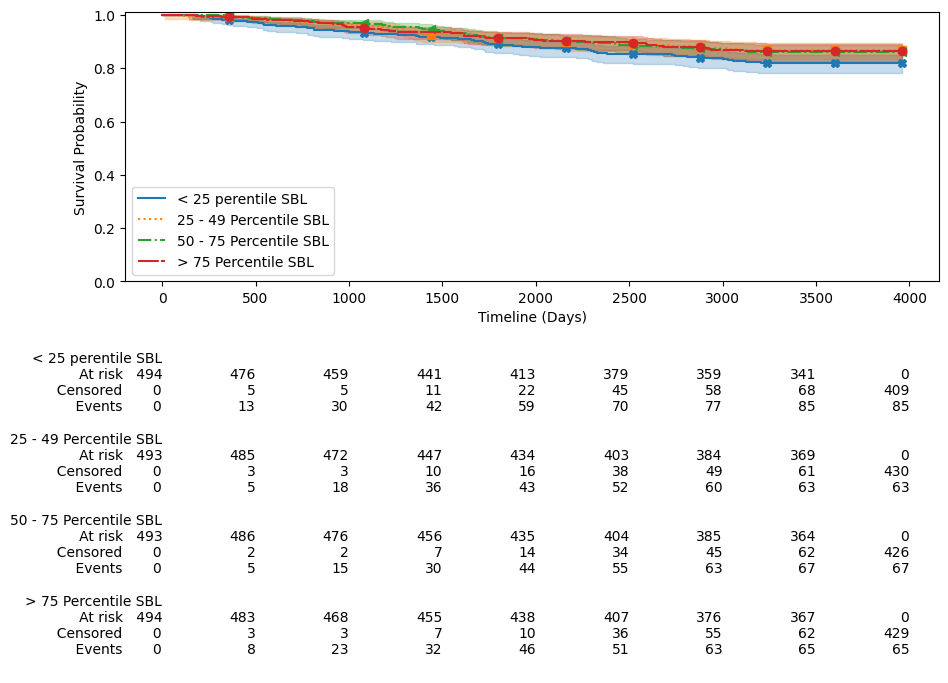

In [42]:
# Kaplan Meier Analysis based on SBL Quartiles 

plt.rcParams["figure.figsize"] = [10.50, 3.50]
kmf = KaplanMeierFitter()
kmf.fit(
    durations=less_25["time"],
    event_observed=less_25["right_tkr"],
    label = '< 25 perentile SBL'
)

kmf.plot_survival_function(
    show_censors=True,linestyle='solid', censor_styles={"ms": 6, "marker": "X"}
)
kmf1 = KaplanMeierFitter()
kmf1.fit(
    durations=to_50["time"],
    event_observed=to_50["right_tkr"],
    label = '25 - 49 Percentile SBL'
)

kmf1.plot_survival_function(
    show_censors=True,linestyle='dotted', censor_styles={"ms": 6, "marker": "s"}
)
kmf2 = KaplanMeierFitter()
kmf2.fit(
    durations=to_75["time"],
    event_observed=to_75["right_tkr"],
    label = '50 - 75 Percentile SBL'
)

kmf2.plot_survival_function(
    show_censors=True,linestyle='dashdot', censor_styles={"ms": 6, "marker": "<"}
)
kmf3 = KaplanMeierFitter()
kmf3.fit(
    durations=above_75["time"],
    event_observed=above_75["right_tkr"],
    label = '> 75 Percentile SBL'
)

kmf3.plot_survival_function(
    show_censors=True,linestyle='dashed',dashes=[10, 1, 10, 1], censor_styles={"ms": 6, "marker": "o"}
)

plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel("Survival Probability")

plt.xlabel("Timeline (Days)")
plt.legend(loc = 'lower left')
from lifelines.plotting import add_at_risk_counts
# add_at_risk_counts(kmf, kmf1, kmf2, kmf3)
plt.savefig('/home/tsurendr/KMF_Curves/New_Analysis/kmf_SBL_RAW.pdf', format='pdf', bbox_inches = 'tight')

#Log-rank test to compare the survival function between various SBL populations
results_multivariate = pairwise_logrank_test(oai_right_temp_SBL_Merged_all['time'], oai_right_temp_SBL_Merged_all['SBL_Group'],oai_right_temp_SBL_Merged_all['right_tkr'])
print(results_multivariate)


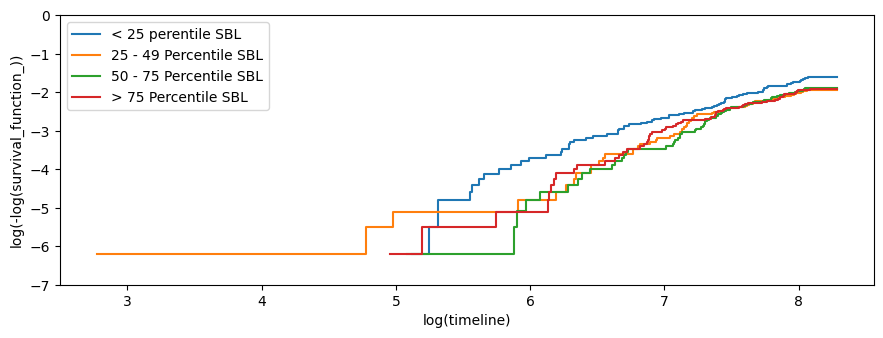

In [43]:
import lifelines
lifelines.plotting.loglogs_plot(kmf)
lifelines.plotting.loglogs_plot(kmf1)
lifelines.plotting.loglogs_plot(kmf2)
lifelines.plotting.loglogs_plot(kmf3)
plt.yticks(np.arange(-7, 1, 1))
# plt.title('Log-Log curve for SBL')
plt.savefig('/home/tsurendr/KMF_Curves/New_Analysis/log-log_SBL_RAW.pdf', format='pdf', bbox_inches = 'tight')